## Transformer Segmentation for Autonomous Driving
>special thanks to [WX Lin](https://github.com/Lin-13)

####   1. Download the data. 
> It is provided in *driving_train_data.h5* and *driving_test_data.h5.* Implement a data loader class to handle the downloaded data. For more information on the dataset please refer to: [CityScapes dataset](https://www.cityscapes-dataset.com/)

In [1]:
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch
import h5py
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
import numpy as np
from tqdm import tqdm
traindata = h5py.File("./option1_driving-segmentation/driving_train_data.h5")
testdata = h5py.File("./option1_driving-segmentation/driving_test_data.h5")
# train_loader = data.DataLoader(dataset=traindata, batch_size=16, shuffle=True, pin_memory=True)


In [19]:
"""
refer to: https://blog.csdn.net/sinat_35779431/article/details/116991936
"""

class MyDataset(data.Dataset):
    def __init__(self, archive,image='rgb',mask='seg',transform = None):
        # super().__init__()
        self.archive = h5py.File(archive, 'r')
        self.data = self.archive[image]
        self.labels = self.archive[mask]
        self.transform = transform
    def __getitem__(self, index):
        image = self.data[index]
        mask = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
            mask = torch.LongTensor(mask)
        return image, mask

    def __len__(self):
        return len(self.labels)

    def close(self):
        self.archive.close()


In [20]:

train_dataset = MyDataset("./option1_driving-segmentation/driving_train_data.h5",transform=ToTensor())
# data = data.ConcatDataset([rgb,seg])
test_dataset = MyDataset("./option1_driving-segmentation/driving_test_data.h5",transform=ToTensor())
train_loader = data.DataLoader(dataset=train_dataset,batch_size=16,drop_last=True,shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=16,drop_last=True,shuffle=True)

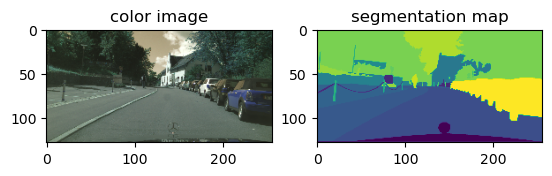

In [21]:
# show train images
rgb = traindata["rgb"]
seg = traindata["seg"]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(rgb[0])
plt.title('color image')
plt.subplot(1,2,2)
seg[0].resize([2975,128,256,3])
plt.imshow(seg[0])
plt.title('segmentation map')
plt.show()

####   2. Define the model.
> Origin code from [CSDN](https://blog.csdn.net/weixin_44510615/article/details/119765864)

In [2]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding=1):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel,padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512,padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512,padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        # print("encode1 output:",encode_pool1.shape)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        # print("encode2 output:",encode_pool2.shape)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # print("encode3 output:",encode_pool3.shape)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # print("bottleneck1 output:",bottleneck1.shape)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        # print("decoder3 output:",decode_block3.shape)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        # print("decoder2 output:",decode_block2.shape)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        # print("decoder1 output:",decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        # print("final output:",final_layer.shape)
        return  final_layer


In [23]:
class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = torch.zeros((self.numClass,)*2)
 
    def pixelAccuracy(self):
        # return all class overall pixel accuracy
        #  PA = acc = (TP + TN) / (TP + TN + FP + TN)
        acc = torch.diag(self.confusionMatrix).sum() /  self.confusionMatrix.sum()
        return acc
 
    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = torch.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
        return classAcc # 返回的是一个列表值，如：[0.90, 0.80, 0.96]，表示类别1 2 3各类别的预测准确率
 
    def meanPixelAccuracy(self):
        classAcc = self.classPixelAccuracy()
        meanAcc = torch.nanmean(classAcc) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
        return meanAcc # 返回单个值，如：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 =  0.89
 
    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = torch.diag(self.confusionMatrix) 
        # 取对角元素的值，返回列表
        union = torch.sum(self.confusionMatrix, axis=1) + torch.sum(self.confusionMatrix, axis=0) - torch.diag(self.confusionMatrix) 
        # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
        IoU = intersection / union  
        # 返回列表，其值为各个类别的IoU
        mIoU = torch.nanmean(IoU) 
        # 求各类别IoU的平均
        return mIoU
 
    def genConfusionMatrix(self, imgPredict, imgLabel): # 同FCN中score.py的fast_hist()函数
        # remove classes from unlabeled pixels in gt image and predict
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = torch.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        confusionMatrix = confusionMatrix.cpu()
        return confusionMatrix
 
    def Frequency_Weighted_Intersection_over_Union(self):
        # FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
        freq = torch.sum(self.confusion_matrix, axis=1) / torch.sum(self.confusion_matrix)
        iu = torch.diag(self.confusion_matrix) / (
                torch.sum(self.confusion_matrix, axis=1) + torch.sum(self.confusion_matrix, axis=0) -
                torch.diag(self.confusion_matrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU
 
 
    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)
 
    def reset(self):
        self.confusionMatrix = torch.zeros((self.numClass, self.numClass))
class KFMean():
    def __init__(self):
        self.acc_data  = 0
        self.count = 0
    def addData(self,data_append):
        self.count +=1
        self.acc_data = self.acc_data * (self.count - 1) / self.count + data_append /self.count
class Lut():
    def __init__(self,lut):
        self.lut = lut
    def transform(self,input:np.ndarray):
        if len(input.shape)!=2:
            raise Exception("dim Error!")
        output = np.zeros(input.shape)
        output = self.lut[input]
        return output

In [25]:
# Visualizing the Model
unet = UNet(in_channel=3,out_channel=30)

#### 3. Define the loss function and optimizer. 

In [26]:
#unet = UNet(in_channel=3,out_channel=30)
#out_channel represents number of segments desired
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
# input = torch.permute(torch.tensor(rgb[0][None],dtype=torch.float),(0,3,1,2))
# label = torch.tensor(seg[0],dtype = torch.long).permute(2,0,1)
input = torch.permute(torch.tensor(rgb[0][None],dtype=torch.float),(0,3,1,2))
label = torch.tensor(seg[0],dtype = torch.long).permute(2,0,1)
outputs = unet(input)
m = outputs.shape[0]
loss = criterion(outputs, label)
loss.backward()
optimizer.step()
input.shape,label.shape


(torch.Size([1, 3, 128, 256]), torch.Size([1, 128, 256]))

#### 4. Train the network

In [ ]:
unet = UNet(in_channel=3,out_channel=34)
# unet.load_state_dict(torch.load("driving-seg-epoch8.pt"))
device = "cuda:0"
print(torch.cuda.is_available())
unet.to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
num_epoch = 30


In [ ]:
losses = np.zeros((num_epoch,len(train_loader)))
mIoUs = np.zeros(num_epoch)
for i in range(num_epoch):
    metric = SegmentationMetric(34)
    bar = tqdm(range(len(train_loader)))
    lossAccmulator = []
    for j,(input,label) in enumerate(train_loader):
        input = input.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        label = torch.permute(label,(3,0,1,2))[0]
        outputs = unet(input)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        losses[i][j] =  loss.detach().cpu().numpy()
        _,predicted = torch.max(outputs,1)
        imgPredict = predicted.squeeze()
        imgLabel = label.squeeze()
        metric.addBatch(imgPredict, imgLabel)
        bar.update()

    mIoU = metric.meanIntersectionOverUnion()
    mIoUs[i] = mIoU.cpu().numpy()
    print("epoch {}: mIoU is : {}.\n".format(i,mIoU))
    bar.close()

In [ ]:
torch.save(unet.state_dict(),"driving-seg-epoch30.pt")
torch.save(unet,"driving-seg-30.pt")

In [ ]:
plt.plot(losses.T)
plt.legend(["epoch {}".format(i) for i in range(num_epoch)])

#### 5. Test the resulting network on examples from an independent test set.

Implement and present:  
    a. Create and save a bar chart showing the test accuracy across each semantic class.  
    b. Predictions and visualizations for (𝑖𝑛𝑝𝑢𝑡, µ, 𝑎𝑙𝑒𝑎𝑡𝑜𝑟𝑖𝑐, 𝑒𝑝𝑖𝑠𝑡𝑒𝑚𝑖𝑐) on 5 different input examples. Please save and visualize the results on each of the 5 different inputs. Since there are 4 visualizations per input, please provide a total of 5*4 = 20 images.  
    c. Comment briefly on how the model’s performance could be improved.  
    d. Please save your code and results for submission.  

In [ ]:
# Comparing the Results
# unet = UNet(in_channel=3,out_channel=34)
# unet.load_state_dict(torch.load("driving-seg-epoch30.pt"))
unet.eval()
unet.to(device)
images0, labels0 =  test_dataset[0]
images0 = images0[None]
labels0 = labels0[None]
labels0 = torch.permute(labels0,(3,0,1,2))[0]
images0 = images0.to(device)

outputs0 = unet(images0)
outputs0 = outputs0.cpu()
_, predicted = torch.max(outputs0, 1)
plt.subplot(211)
plt.imshow(predicted[0])
plt.subplot(212)
plt.imshow(labels0[0])



In [ ]:
device = "cuda"
# unet = UNet(in_channel=3,out_channel=34)
# unet.load_state_dict(torch.load("driving-seg.pt"))
unet.to(device)
# unet = torch.load("driving-seg-unet.pt")
criterion = torch.nn.CrossEntropyLoss()

unet.eval()
losses_test = np.zeros((len(test_loader)))

metric = SegmentationMetric(34)
bar = tqdm(range(len(test_loader)))
lossAccmulator = []
with torch.no_grad():
    for i,(input,label) in enumerate(test_loader):
        input = input.to(device)
        label = torch.permute(label,(3,0,1,2))[0]
        label = label.to(device)
    
        outputs = unet(input)
        loss = criterion(outputs, label)
        
        losses_test[i] =  loss.detach().cpu().numpy()
        _,predicted = torch.max(outputs,1)
        imgPredict = predicted.squeeze()
        imgLabel = label.squeeze()
        metric.addBatch(imgPredict, imgLabel)
        bar.update()
mIoU = metric.meanIntersectionOverUnion()
print("test: mIoU is :{}.\n".format(mIoU))
bar.close()

In [ ]:
plt.plot(losses_test)

In [ ]:
losses_test.mean()

In [ ]:
plt.plot(losses[0][:])
plt.plot(losses[-1][:])
plt.legend(["epoch 1","epoch {}".format(num_epoch)])

In [ ]:
np.mean(losses,axis = 1)

In [ ]:
np.save("losses-epoch30.npy",losses)
np.save("mIoUs-epoch30.npy",mIoUs)

In [ ]:
plt.plot(np.mean(losses,axis = 1))
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
plt.plot(mIoUs)
plt.xlabel("epoch")
plt.ylabel("mIoU")
print("test_dataset: mIoU=",mIoU)

In [3]:
import cv2
class VideoLoader():
    def __init__(self,file:str,batch_size:int = 1,transform = ToTensor(),resize_shape :tuple = None):
        self.cap = cv2.VideoCapture(file)
        self.batch_size = batch_size
        self.idx = 0
        self.transform = transform
        if resize_shape is not None:
            self.resized_shape = resize_shape
        else:
            self.resized_shape = self.frameshape()
        if not self.cap.isOpened():
            raise Exception("file error")
    def __iter__(self):
        return self
    def __next__(self):
        if self.idx >= int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT)):
            self.idx = 0
            raise StopIteration
        if self.cap.get(cv2.CAP_PROP_FRAME_COUNT) -self.idx < self.batch_size:
            size  = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) -self.idx)
        else:
            size = self.batch_size
        next = torch.zeros((size,
                            3,
                        #  int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                        #  int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            *self.resized_shape
                        ),dtype=torch.float)
        for i in range(size):
            success,frame = self.cap.read()
            if self.resized_shape is not None:
                frame = cv2.resize(frame,(self.resized_shape[1],self.resized_shape[0]))
            if success:
                if self.transform is not None:
                    frame = self.transform(frame)
                next[i] = frame
            pass
        self.idx +=self.batch_size
        return next
    def frameshape(self):
        return (int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
    def fps(self):
        return self.cap.get(cv2.CAP_PROP_FPS)
    def __len__(self):
        return int(np.ceil(self.cap.get(cv2.CAP_PROP_FRAME_COUNT)/self.batch_size))

In [6]:
video_batch = 32
video = VideoLoader("images/test.mp4",video_batch,resize_shape=(128,256))
# video = VideoLoader("images/test.mp4",video_batch)
video.cap.get(cv2.CAP_PROP_FRAME_COUNT),len(video),video.resized_shape


(15714.0, 492, (128, 256))

In [7]:
bar = tqdm(range(len(video)))
device = "cuda"
unet = torch.load("driving-seg-30.pt")
unet.to(device)
unet.eval()
# video output
video_write = cv2.VideoWriter("images/test128p.avi",
                              cv2.VideoWriter_fourcc('M','J','P','G'), 
                              video.fps(), (video.resized_shape[1],video.resized_shape[0]),
                              True)
with torch.no_grad():
    for i,data in  enumerate(video):
        data = data.to(device)
        outputs = unet(data)
        _,predicted = torch.max(outputs,1)
        preds = predicted.detach().cpu().numpy()
        # print("data: {}\n".format(data.shape))
        for j in range(preds.shape[0]):
            img = np.ones((*video.resized_shape,3),dtype=np.uint8)
            img[:,:,0]=preds[j]/50*255 + 50
            img[:,:,1]=180
            img[:,:,2]=180
            img = cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
            video_write.write(img)
        bar.update()
    video_write.release()
    bar.close()

100%|██████████| 492/492 [05:21<00:00,  1.53it/s]


In [59]:
# lookup = Lut(np.array([2,4,6,8])) #1 dim
lookup = Lut(np.array([[2,1],[4,1],[6,1],[8,1]]))
lut_input = np.array([1,2,3,0]).reshape(2,2)
lut_output = lookup.transform(lut_input)
lut_output

array([[[4, 1],
        [6, 1]],

       [[8, 1],
        [2, 1]]])